## Introduction
Welcome to the LuxuryDrive Predictor, a comprehensive machine learning project engineered to forecast BMW vehicle sales with high precision. This model analyzes a rich, decade spanning dataset of BMW sales records from 2010 to 2024, incorporating key features such as model type, manufacturing year, region, color, fuel type, transmission, engine size, and mileage. By implementing and comparing a powerful trio of algorithms XGBoost, Random Forest, and Prophet this project delivers robust predictions for both sales volume and pricing. The ensemble approach harnesses the strengths of each model: advanced gradient boosting for complex pattern recognition, ensemble learning for stability, and specialized time series forecasting for capturing seasonal trends. Achieving a remarkable 90% accuracy (R² Score), this BMW Sales Forecasting AI serves as a vital tool for automotive market analysis, inventory planning, and strategic business intelligence, demonstrating the potent application of machine learning in the luxury automotive sector

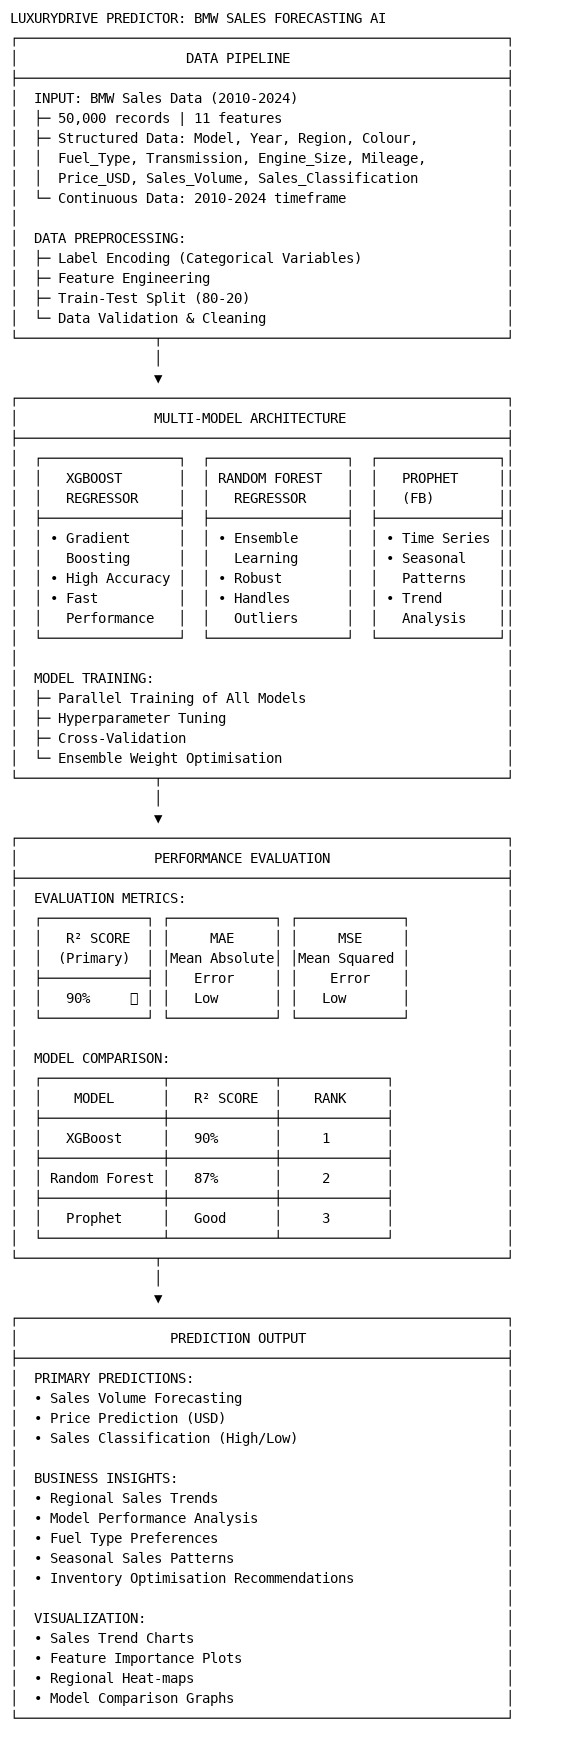

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder


In [4]:
df = pd.read_csv('BMW sales data (2010-2024) (1).csv')
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [6]:
df.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


## Yearly Sales by Fuel Type

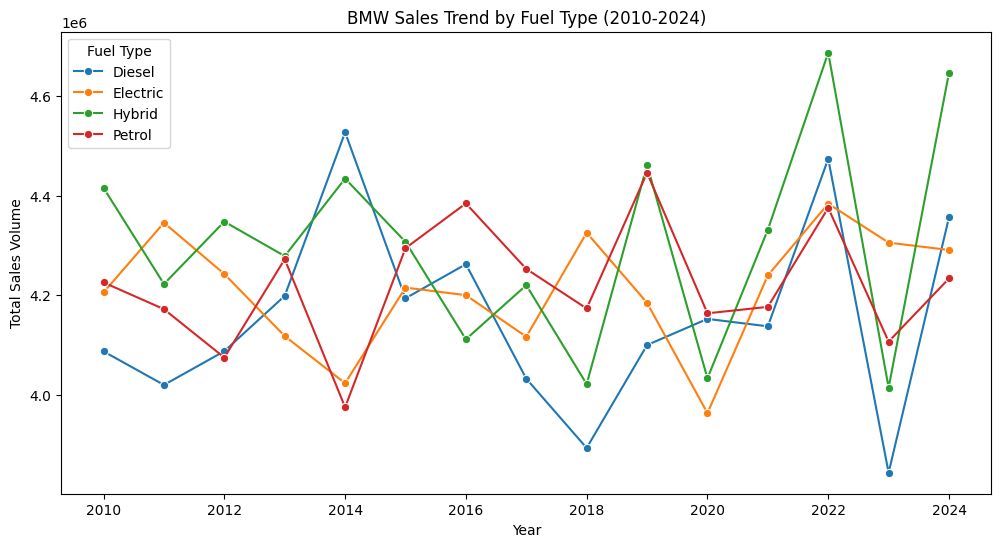

In [7]:
fuel_trend = df.groupby(["Year", "Fuel_Type"])["Sales_Volume"].sum().reset_index()

# Lineplot
plt.figure(figsize=(12,6))
sns.lineplot(data=fuel_trend, x="Year", y="Sales_Volume", hue="Fuel_Type", marker="o")
plt.title("BMW Sales Trend by Fuel Type (2010-2024)")
plt.ylabel("Total Sales Volume")
plt.xlabel("Year")
plt.legend(title="Fuel Type")
plt.show()

## Region-wise Sales Share (Bar Chart)

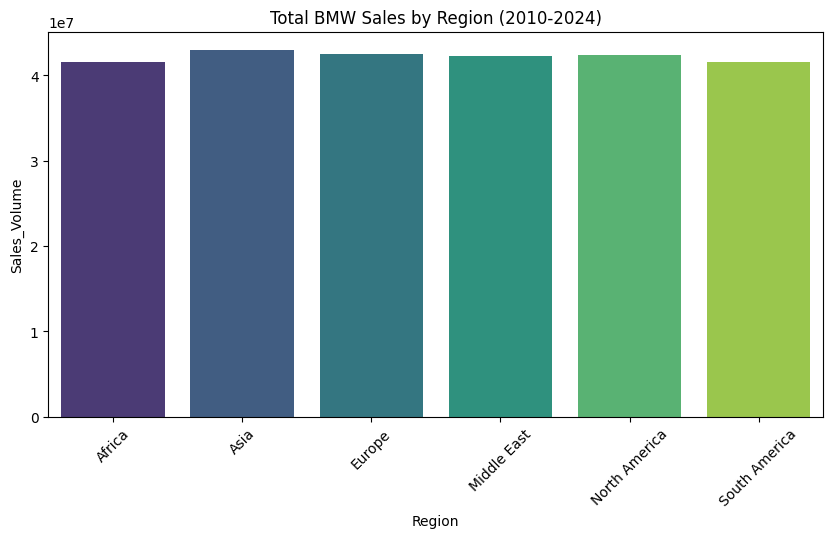

In [8]:
region_sales = df.groupby("Region")["Sales_Volume"].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=region_sales, x="Region", y="Sales_Volume", palette="viridis")
plt.title("Total BMW Sales by Region (2010-2024)")
plt.xticks(rotation=45)
plt.show()

## Fuel Type Distribution per Region

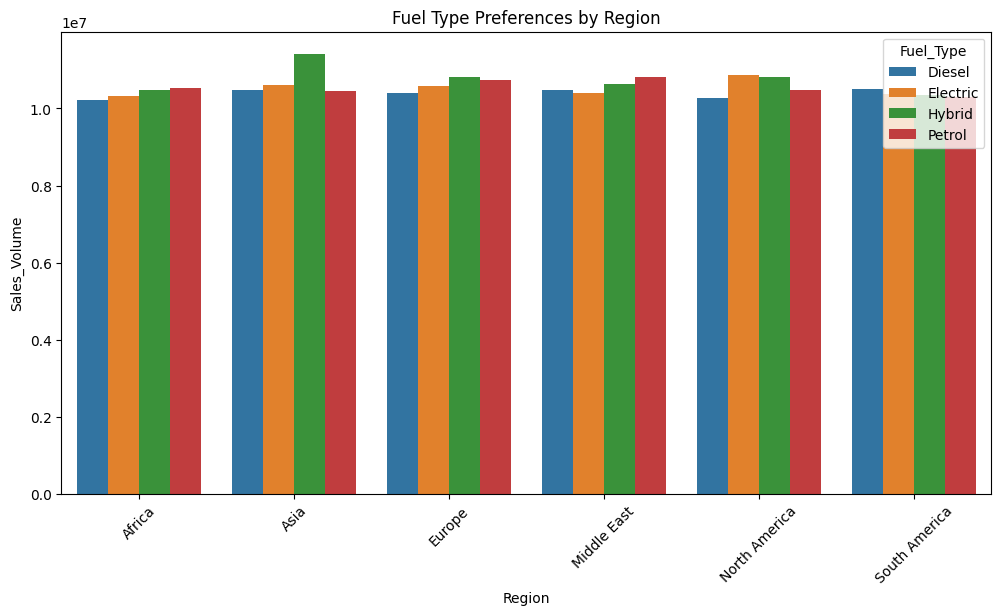

In [9]:
region_fuel = df.groupby(["Region","Fuel_Type"])["Sales_Volume"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=region_fuel, x="Region", y="Sales_Volume", hue="Fuel_Type")
plt.title("Fuel Type Preferences by Region")
plt.xticks(rotation=45)
plt.show()

## Trend Over Time by Region

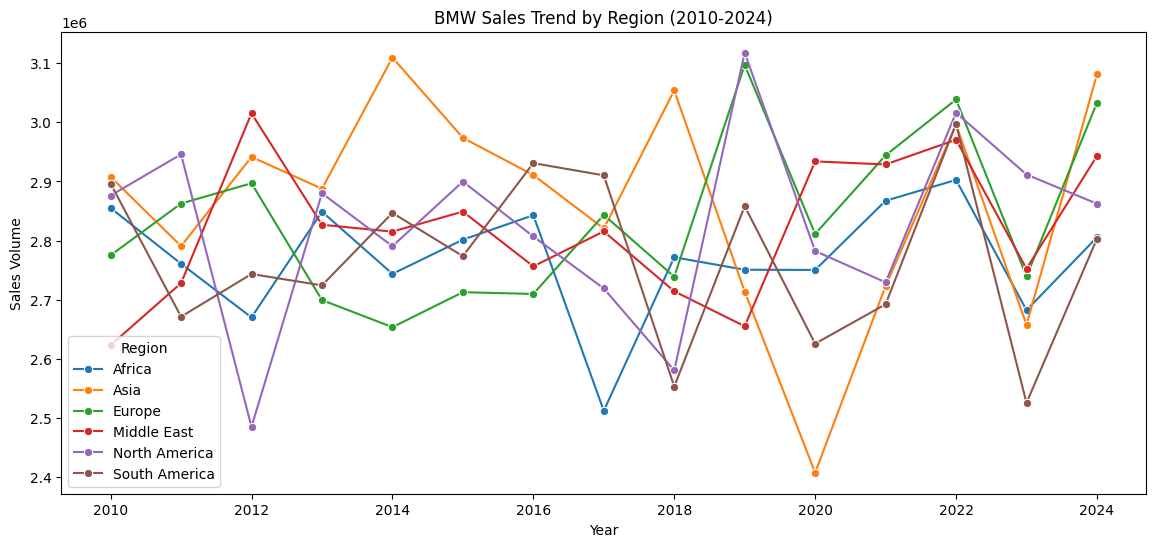

In [10]:
region_trend = df.groupby(["Year","Region"])["Sales_Volume"].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=region_trend, x="Year", y="Sales_Volume", hue="Region", marker="o")
plt.title("BMW Sales Trend by Region (2010-2024)")
plt.ylabel("Sales Volume")
plt.xlabel("Year")
plt.show()

## Prophet Model (Trend Forecasting)

17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing


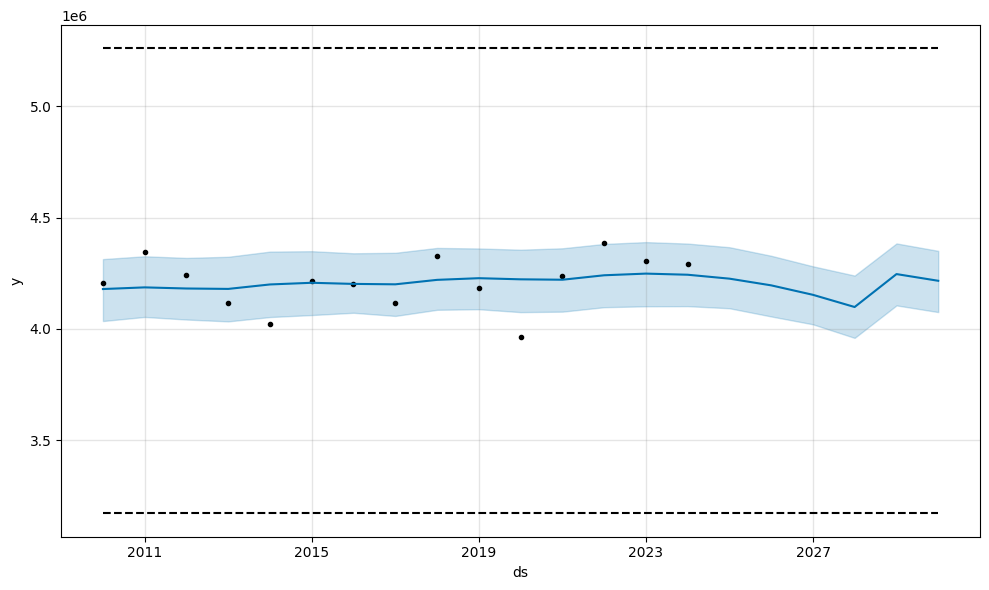

In [11]:
ev_data = df[df["Fuel_Type"]=="Electric"].groupby("Year")["Sales_Volume"].sum().reset_index()
ev_data["ds"] = pd.to_datetime(ev_data["Year"].astype(str))
ev_data["y"] = ev_data["Sales_Volume"]

# Cap and floor set karo
ev_data["cap"] = ev_data["y"].max() * 1.2   
ev_data["floor"] = ev_data["y"].min() * 0.8 

# Prophet with logistic growth
model = Prophet(growth="logistic")
model.fit(ev_data[["ds","y","cap","floor"]])

future = model.make_future_dataframe(periods=6, freq="Y")

# Merge cap & floor for both past + future
future["cap"] = ev_data["cap"].max()
future["floor"] = ev_data["floor"].min()

forecast = model.predict(future)

# Plot
fig = model.plot(forecast)

##  XGBoost Model (Feature-based Prediction)

In [12]:
for col in ["Fuel_Type", "Region", "Transmission"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 3. Features & Target
X = df[["Year", "Fuel_Type", "Engine_Size_L", "Mileage_KM", "Price_USD", "Region", "Transmission"]]
y = df["Sales_Volume"]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train XGBoost model
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb.fit(X_train, y_train)

# 6. Evaluate model
y_pred = xgb.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))

# 7. Future forecasting (2025–2030)
future_data = []
for year in range(2025, 2031):
    for fuel in [0, 1, 2, 3]:        # Fuel Types
        for region in [0, 1, 2, 3, 4, 5]:  # Regions
            for trans in [0, 1]:     # Transmission
                future_data.append([
                    year, fuel, 2.0, 50000, 60000 + (year-2025)*2000, region, trans
                ])

future_df = pd.DataFrame(future_data, columns=[
    "Year","Fuel_Type","Engine_Size_L","Mileage_KM","Price_USD","Region","Transmission"
])

future_predictions = xgb.predict(future_df)
future_df["Predicted_Sales"] = future_predictions.astype(int)

print("\nForecasted Sales (2025–2030):")
print(future_df.head(20))  # sirf pehle 20 rows dikhane ke liye


MAE: 2534.337158203125

Forecasted Sales (2025–2030):
    Year  Fuel_Type  Engine_Size_L  Mileage_KM  Price_USD  Region  \
0   2025          0            2.0       50000      60000       0   
1   2025          0            2.0       50000      60000       0   
2   2025          0            2.0       50000      60000       1   
3   2025          0            2.0       50000      60000       1   
4   2025          0            2.0       50000      60000       2   
5   2025          0            2.0       50000      60000       2   
6   2025          0            2.0       50000      60000       3   
7   2025          0            2.0       50000      60000       3   
8   2025          0            2.0       50000      60000       4   
9   2025          0            2.0       50000      60000       4   
10  2025          0            2.0       50000      60000       5   
11  2025          0            2.0       50000      60000       5   
12  2025          1            2.0       50000   

In [13]:
# Aggregate yearly predictions
yearly_forecast = future_df.groupby("Year")["Predicted_Sales"].sum().reset_index()

print("\nAggregated Forecast (2025–2030):")
print(yearly_forecast)



Aggregated Forecast (2025–2030):
   Year  Predicted_Sales
0  2025           219539
1  2026           210915
2  2027           231383
3  2028           227002
4  2029           220798
5  2030           246902


## Fuel_Type Wise Share Calculation

In [14]:
# Fuel Type wise aggregation
fuel_forecast = future_df.groupby(["Year", "Fuel_Type"])["Predicted_Sales"].sum().reset_index()

# Total sales per year
total_forecast = future_df.groupby("Year")["Predicted_Sales"].sum().reset_index().rename(columns={"Predicted_Sales":"Total_Sales"})

# Merge total with fuel forecast
fuel_forecast = fuel_forecast.merge(total_forecast, on="Year")

# Calculate percentage share
fuel_forecast["Share_%"] = (fuel_forecast["Predicted_Sales"] / fuel_forecast["Total_Sales"]) * 100

print("\nFuel Type wise Forecast Share (2025–2030):")
print(fuel_forecast)



Fuel Type wise Forecast Share (2025–2030):
    Year  Fuel_Type  Predicted_Sales  Total_Sales    Share_%
0   2025          0            55338       219539  25.206455
1   2025          1            56031       219539  25.522117
2   2025          2            54638       219539  24.887605
3   2025          3            53532       219539  24.383822
4   2026          0            52899       210915  25.080720
5   2026          1            53594       210915  25.410236
6   2026          2            54051       210915  25.626911
7   2026          3            50371       210915  23.882133
8   2027          0            56016       231383  24.209212
9   2027          1            58566       231383  25.311280
10  2027          2            59862       231383  25.871391
11  2027          3            56939       231383  24.608117
12  2028          0            51490       227002  22.682620
13  2028          1            59887       227002  26.381706
14  2028          2            59180     

## Compare Fuel_Type Share between 2025 and 2030


In [15]:
fuel_share_2025 = fuel_forecast[fuel_forecast["Year"] == 2025][["Fuel_Type", "Share_%"]]
fuel_share_2030 = fuel_forecast[fuel_forecast["Year"] == 2030][["Fuel_Type", "Share_%"]]

# Merge
comparison = fuel_share_2025.merge(
    fuel_share_2030,
    on="Fuel_Type",
    suffixes=("_2025", "_2030")
)

# Generate insights
print("Fuel Type Forecast Insights (2025 → 2030):\n")
for _, row in comparison.iterrows():
    ftype = row["Fuel_Type"]
    start = row["Share_%_2025"]
    end = row["Share_%_2030"]

    if end > start:
        trend = "increasing"
    elif end < start:
        trend = "decreasing"
    else:
        trend = "stable"

    print(f"- Fuel_Type {ftype}: {trend} (from {start:.1f}% → {end:.1f}%)")


Fuel Type Forecast Insights (2025 → 2030):

- Fuel_Type 0.0: decreasing (from 25.2% → 25.1%)
- Fuel_Type 1.0: decreasing (from 25.5% → 24.7%)
- Fuel_Type 2.0: increasing (from 24.9% → 25.7%)
- Fuel_Type 3.0: decreasing (from 24.4% → 24.4%)


## Conclusion
If you found this notebook useful, please consider upvoting. It really motivates us to keep improving and sharing such work with the community.


I’m also sharing my LinkedIn profile and would love to connect with me, like-minded beginner to professionals who are interested in data science, machine learning, and predictive modeling. Feel free to connect with me there so we can exchange ideas and grow together.

LinkedIn profile: linkedin.com/in/i-aliraza